# Setup

This is just some python magic to make running scripts faster and plotting nicer.

In [1]:
import numpy as np, pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

%matplotlib inline
%load_ext autoreload
%autoreload 2

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 16,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
    'font.family':"sans-serif",
   'font.sans-serif':'Arial',
   'text.usetex': False,
   }

rcParams.update(params)

Let's load the MNIST dataset

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

def get_variable(shape):
    initial = tf.random_normal(shape)
    return tf.Variable(initial)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


**Note: to reduce the number of parameters, I have first performed a 2x2 max-pooling on the MNIST images to produces images of size 7x7, and then classified these images. This reduces the accuracy of a 1-hidden layer fully-connected network from about 92% to 84%. This pooling can be changed by changing the parameter ``pool`` in the methods below.**

# Regularization

(@Jaime, here's the method you can use to add more regularization kinds)

In [3]:
def regularize(loss, weights, reg_kind=None, reg_value=None):
    if reg_kind is None:
        return loss
    elif reg_kind=='L1':
        print("Adding L1 regularization")
        return loss + reg_value*tf.reduce_mean(tf.abs(weights))
    elif reg_kind=='DZ':    
        print("Adding DZ regularization")
        return loss + reg_value*DZ_reg(weights)
    elif reg_kind=='DZ+L1':    
        print("Adding DZ+L1 regularization")
        return loss + reg_value[0]*DZ_reg(weights)+reg_value[1]*tf.reduce_mean(tf.abs(weights))
    else:
        raise ValueError("Invalid value for parameter: reg_kind")

In [4]:
def DZ_reg(weights):
    d1,d2=weights.shape
    d1,d2=int(d1),int(d2)
    n_chan= d2//d1
    weights_rolled=tf.manip.roll(tf.reshape(weights,[n_chan,d1,d1]), shift=[-1,-1], axis=[1,2])
    result=tf.reduce_mean(tf.abs(tf.reshape(weights,[n_chan,d1,d1])-weights_rolled))
    return result


# Fully Connected

The architecture is: FC-49 | FC-10
 
To increase flexibility, I have included a parameter called ``num_channels``. By changing this parameter, one can increase the number of weights. For example, if ``num_channels`` is 3, then the architecture is:

The architecture is: FC-147 | FC-10

In [5]:
def fully_connected(pool=4, num_channels=10, verbose=True, return_weights=False, reg_kind=None, reg_value=None):
    
    d = int(784/pool/pool)
    x = tf.placeholder(tf.float32, [None, 784])


    #hidden layer
    W_fc1 = get_variable([d, d*num_channels])
    b_fc1 = get_variable([d*num_channels])
    # W_fc1 = weight_variable([784, 7840])
    # b_fc1 = bias_variable([7840])
    x_reshaped = tf.reshape(x, [-1, 28, 28, 1])
    x_reshaped = tf.nn.max_pool(x_reshaped, [1, pool, pool,1], [1, pool, pool, 1], padding='SAME')
    x_reshaped = tf.reshape(x_reshaped, [-1, d])
    h_fc1 = tf.sigmoid(tf.matmul(x_reshaped, W_fc1) + b_fc1)

    #output layer
    W_fc2 = get_variable([d*num_channels, 10])
    # W_fc2 = weight_variable([7840, 10])
    b_fc2 = get_variable([10])
    y = tf.matmul(h_fc1, W_fc2) + b_fc2

    y_ = tf.placeholder(tf.float32, [None, 10])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    loss = regularize(loss, W_fc1, reg_kind, reg_value)
    train_step = tf.train.GradientDescentOptimizer(3.0).minimize(loss)

    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        for i in range(1000):
            batch = mnist.train.next_batch(100)
            train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            if i%100==0:
                accuracy_train = accuracy.eval(feed_dict={x: mnist.train.images, y_: mnist.train.labels})
                accuracy_valid = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
                if verbose:
                    print('Train acc:',accuracy_train, 'Valid acc:',accuracy_valid)
        
        return_values = [accuracy_train, accuracy_valid]
        if return_weights:
            return_values.append(sess.run(W_fc1))
        
    return return_values

In [6]:
fully_connected(num_channels=1)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Train acc: 0.10221818 Valid acc: 0.1018
Train acc: 0.7446727 Valid acc: 0.7557
Train acc: 0.8079818 Valid acc: 0.81
Train acc: 0.78981817 Valid acc: 0.7915
Train acc: 0.8006909 Valid acc: 0.808
Train acc: 0.8349091 Valid acc: 0.8378
Train acc: 0.85045457 Valid acc: 0.8534
Train acc: 0.83992726 Valid acc: 0.8423
Train acc: 0.8508 Valid acc: 0.8512
Train acc: 0.84996367 Valid acc: 0.852


[0.84996367, 0.852]

# 1-D Convolutional Networks

 The architecture is: CONV-3-NUM_CHANNELS | FC-10


In [38]:
def convolutional(pool=4, num_channels=10, verbose=True,return_weights=False,reg_kind=None, reg_value=None):

    d = int(784/pool/pool)
    x = tf.placeholder(tf.float32, [None, 784])

    #hidden layer
    W_conv = get_variable([3, 1, num_channels])
    b_conv = get_variable([num_channels])
    #h_fc1 = tf.sigmoid(tf.matmul(x, W_fc1) + b_fc1)

    x_reshaped = tf.reshape(x, [-1, 28, 28, 1])
    x_reshaped = tf.nn.max_pool(x_reshaped, [1, pool, pool,1], [1, pool, pool, 1], padding='SAME')
    #x_reshaped = tf.reshape(x_reshaped, [-1, d])

    h = tf.nn.conv1d(tf.reshape(x_reshaped, [-1, d, 1]), W_conv, 1, "SAME")
    h = tf.nn.sigmoid(h + b_conv)

    #output layer
    W_fc2 = get_variable([d*num_channels, 10])
    b_fc2 = get_variable([10])
    y = tf.matmul(tf.reshape(h, [-1, d*num_channels]), W_fc2) + b_fc2

    y_ = tf.placeholder(tf.float32, [None, 10])
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    loss = regularize(loss, W_fc2, reg_kind, reg_value)
    train_step = tf.train.GradientDescentOptimizer(3.0).minimize(loss)

    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        for i in range(1000):
            batch = mnist.train.next_batch(100)
            train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            if i%100==0:
                accuracy_train = accuracy.eval(feed_dict={x: mnist.train.images, y_: mnist.train.labels})
                accuracy_valid = accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
                if verbose:
                    print('Train acc:',accuracy_train, 'Valid acc:',accuracy_valid)
                
        return_values = [accuracy_train, accuracy_valid]
        if return_weights:
            return_values.append(sess.run(W_conv))
    
    return return_values

In [8]:
convolutional()

Train acc: 0.099436365 Valid acc: 0.1032
Train acc: 0.10569091 Valid acc: 0.109
Train acc: 0.45405453 Valid acc: 0.4599
Train acc: 0.6953273 Valid acc: 0.7057
Train acc: 0.74889094 Valid acc: 0.7589
Train acc: 0.73867273 Valid acc: 0.7462
Train acc: 0.7773455 Valid acc: 0.7849
Train acc: 0.79034543 Valid acc: 0.796
Train acc: 0.79045457 Valid acc: 0.794
Train acc: 0.7883273 Valid acc: 0.796


[0.7883273, 0.796]

In [9]:
fc_trains = list()
fc_valids = list()
conv_trains = list()
conv_valids = list()
i_s = range(1, 10, 2)

for i in i_s:
    print(i)
    t, v = fully_connected(num_channels=i, verbose=False)
    fc_trains.append(t)
    fc_valids.append(v)
    t, v = convolutional(num_channels=i, verbose=False)
    conv_trains.append(t)
    conv_valids.append(v)

1
3
5
7
9


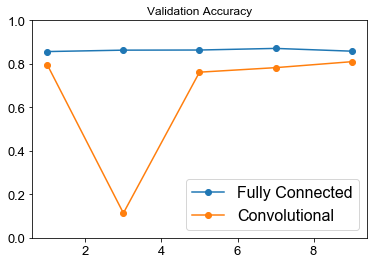

In [10]:
plt.plot(i_s, fc_valids, '-o', label='Fully Connected')
plt.plot(i_s, conv_valids, '-o', label='Convolutional')
plt.title('Validation Accuracy')
plt.legend()
plt.ylim([0, 1]);

Strangely enough, it seems that the fully-connected network is performing better than the 1D convolution! This means that regularization of the form that we propose may actually _worsen_ performance. Nevertheless, let's see if the weights take a "convolutional" structure with proper regularization.

# Let's Take a Look at the Weights

Let's define a method that takes in the weights of the fully-connected network and visualizes them.

In [11]:
def visualize_weights(weights, num_channels, num_digits=5):
    weights = np.abs(weights.reshape(49, 49, num_channels)) # we care about magnitude
    fig, axes = plt.subplots(1,num_channels,  figsize=[ 2*num_channels,2])
    for i in range(num_channels):
        axes[i].imshow(weights[:, :, i], cmap='gray', vmin=np.min(weights), vmax=np.max(weights))  

### Without any regularization

In [12]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True)

In [13]:
print(accuracy_valid)

0.8725


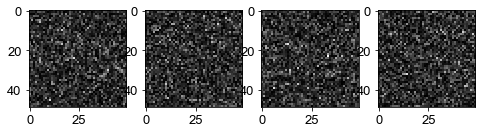

In [14]:
visualize_weights(weights, num_channels=4)

### With $L_1$ regularization

In [15]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='L1', reg_value=1)

Adding L1 regularization


The accuracy is pretty much unchanged:

In [16]:
print(accuracy_valid)

0.8702


But the weights are visibly sparser

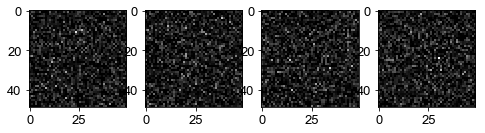

In [17]:
visualize_weights(weights, num_channels=4)

Adding L1 regularization
0.7979


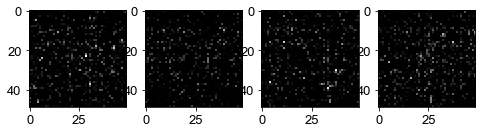

In [18]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='L1', reg_value=5)
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

Adding L1 regularization
0.6839


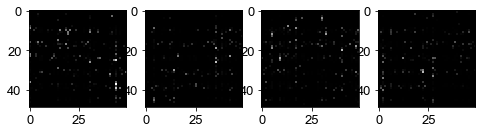

In [19]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='L1', reg_value=10)
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

### With DZ regularization

Adding DZ regularization
0.8448


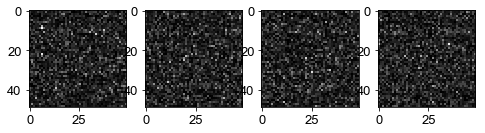

In [20]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='DZ', reg_value=1)
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

Adding DZ regularization
0.7948


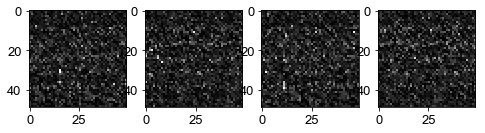

In [21]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='DZ', reg_value=3)
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

Adding DZ regularization
0.8099


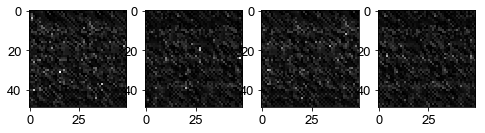

In [22]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='DZ', reg_value=5)
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

Adding DZ regularization
0.823


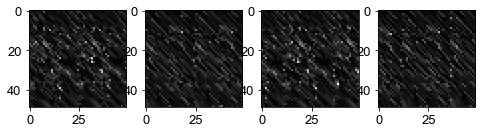

In [23]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='DZ', reg_value=10)
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

Adding DZ+L1 regularization
0.7746


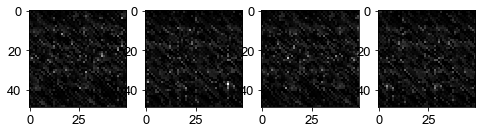

In [24]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='DZ+L1', reg_value=[5,0.5])
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

Adding DZ+L1 regularization
0.8013


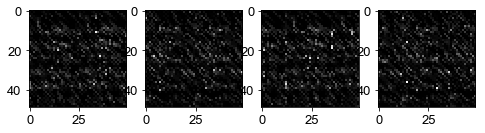

In [25]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='DZ+L1', reg_value=[5,1])
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

Adding DZ+L1 regularization
0.8034


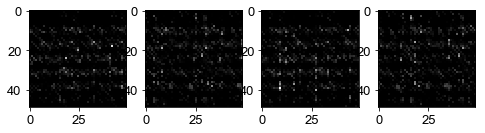

In [26]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='DZ+L1', reg_value=[5,2])
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

Adding DZ+L1 regularization
0.7903


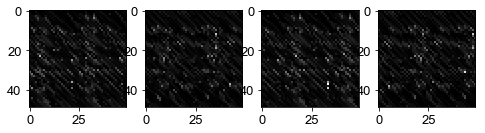

In [27]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='DZ+L1', reg_value=[10,0.5])
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

Adding DZ+L1 regularization
0.7702


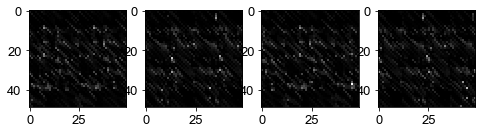

In [28]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='DZ+L1', reg_value=[10,1])
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

Adding DZ+L1 regularization
0.7693


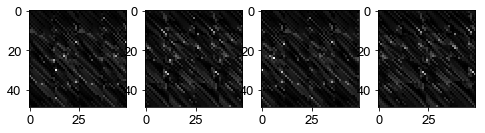

In [29]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='DZ+L1', reg_value=[15,0.2])
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

Adding DZ+L1 regularization
0.7451


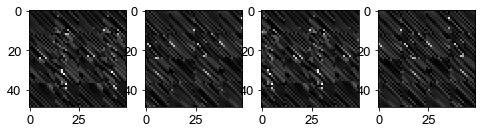

In [30]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='DZ+L1', reg_value=[20,0.1])
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

Adding DZ+L1 regularization
0.7


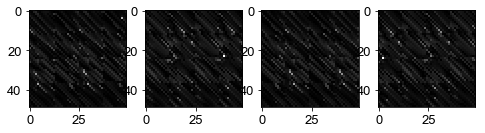

In [31]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='DZ+L1', reg_value=[20,0.2])
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

Adding DZ+L1 regularization
0.7931


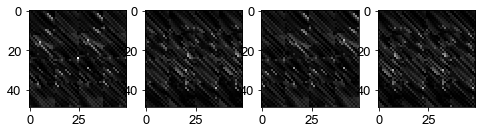

In [32]:
accuracy_train, accuracy_valid, weights = fully_connected(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind='DZ+L1', reg_value=[20,0.4])
print(accuracy_valid)
visualize_weights(weights, num_channels=4)

In [40]:
accuracy_train, accuracy_valid, weights = convolutional(num_channels=4, verbose=False, return_weights=True,
                                                         reg_kind=None, reg_value=[20,0.4])
print(accuracy_valid)

0.7751
